In [1]:
import riversound, glob, obspy, matplotlib, datetime
import numpy as np
import matplotlib.pyplot as plt
import gemlog
import pandas as pd
from pandas import *
import matplotlib.patches as mpatches
import obspy.signal 
import math
import scipy
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from matplotlib import animation
import PIL
from PIL import Image, ImageFilter
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import os
## FFT works best when data length is a power of 2, so use this function to help determine window size.
def next_power_2(x):
    return int(2**np.ceil(np.log2(x)))
def reformat(l): # turn list l into a numpy array
    lengths = np.array([len(i) for i in l])
    normal_length = lengths[lengths > 0][0]
    if any((lengths != 0) & (lengths != normal_length)):
        raise ValueError('nonzero lengths of elements of l must all be the same')
    for i in np.where(lengths == 0)[0]:
        l[i] = np.zeros(normal_length)
    return np.array(l)
def interp_times(t_out, t, q):
    t_out = np.array([x.timestamp() for x in t_out])
    t = np.array([x.timestamp() for x in t])
    return np.interp(t_out, t, q)
    
## define paths containing infrasound and audible data, read in and filter data
path = '/home/scott/bender/gradschool/data/2022_Pool/'
path_audible = path + 'iMic/07-01_Div/'
aud_files  = sorted(glob.glob(path_audible + '*.wav'))
path_photos = path + 'pool_screenshots/07-01/'

times_audible = []
meanspec_list_audible = []
medspec_list_audible = []
power_audible = []
xlsx = ExcelFile('R_all.xlsx')
data_all = xlsx.parse(xlsx.sheet_names[0])
columns = ['d_initial','d_final','d_t_initial','d_t_final','sig_start','sig_end','phase1start','phase1end','phase2start','phase2end','phase3start','phase3end','phase4start','phase4end','spec1start','spec1end','spec2start','spec2end','spec3start','spec3end','spec4start','spec4end','spec5start','spec5end']
data_all.set_index(columns)
R1 = data_all[:1]
R2 = data_all[1:2]
R3 = data_all[2:3]
R4 = data_all[3:4]
R5 = data_all[4:5]
R6 = data_all[5:6]
R7 = data_all[6:7]
R8 = data_all[7:8]
R9 = data_all[8:9]
R10 = data_all[9:10]
R11 = data_all[10:11]
R12 = data_all[11:12]
R13 = data_all[12:13]
R14 = data_all[13:14]
R15 = data_all[14:15]
R16 = data_all[15:16]
R17 = data_all[16:17]
R18 = data_all[17:18]
R19 = data_all[18:19]
R20 = data_all[19:20]
R21 = data_all[20:21]
R22 = data_all[21:22]
R23 = data_all[22:23]
R24 = data_all[23:24]
R25 = data_all[24:25]
R26 = data_all[25:26]
R27 = data_all[26:27]
R28 = data_all[27:28]
R29 = data_all[28:29]
R30 = data_all[29:30]
R31 = data_all[30:31]
R32 = data_all[31:32]
R33 = data_all[32:33]
R34 = data_all[33:34]
R35 = data_all[34:35]
## SET DATA ##
dataSet = [R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16,R17,R18,R19,R20,R21,R22,R23,R24,R25,R26,R27,R28,R29,R30,R31,R32,R33,R34,R35]
print(dataSet[0].sig_start[0])
# set Variable of Interest
voi = 'Jet Height' 

54.0


27
.MicW_i437.. | 2022-11-18T16:49:09.000000Z - 2022-11-18T16:51:00.146646Z | 48000.0 Hz, 5335040 samples
28
.MicW_i437.. | 2022-11-18T16:59:56.000000Z - 2022-11-18T17:02:13.621312Z | 48000.0 Hz, 6605824 samples
29
.MicW_i437.. | 2022-11-18T17:24:24.000000Z - 2022-11-18T17:26:11.093312Z | 48000.0 Hz, 5140480 samples
30
.MicW_i437.. | 2022-11-18T17:34:00.000000Z - 2022-11-18T17:36:14.314646Z | 48000.0 Hz, 6447104 samples


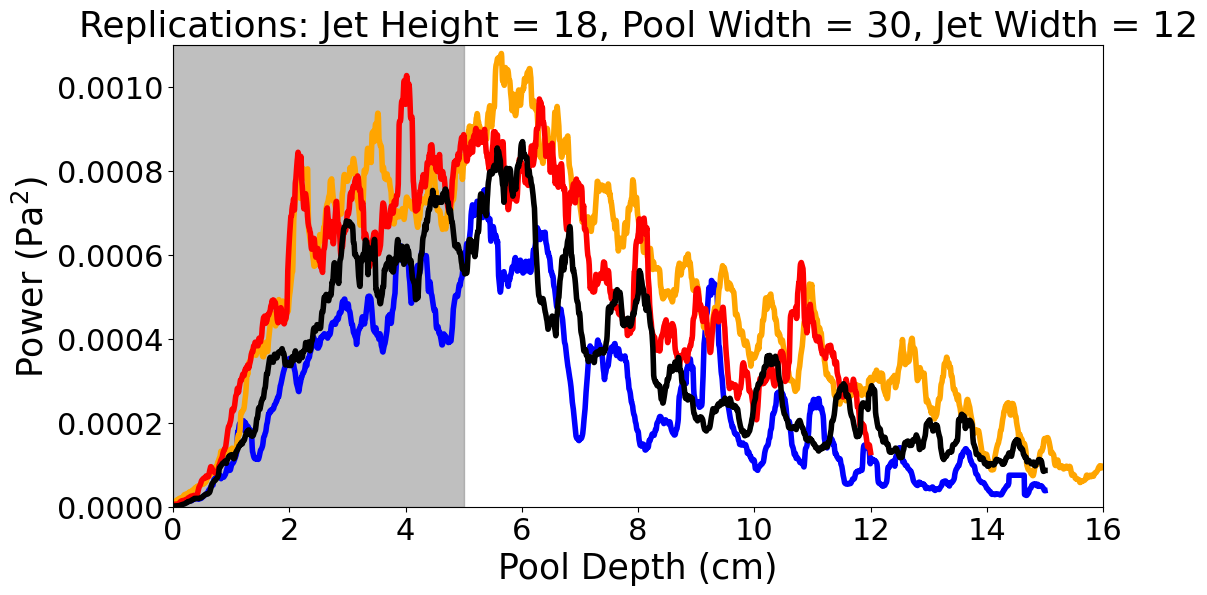

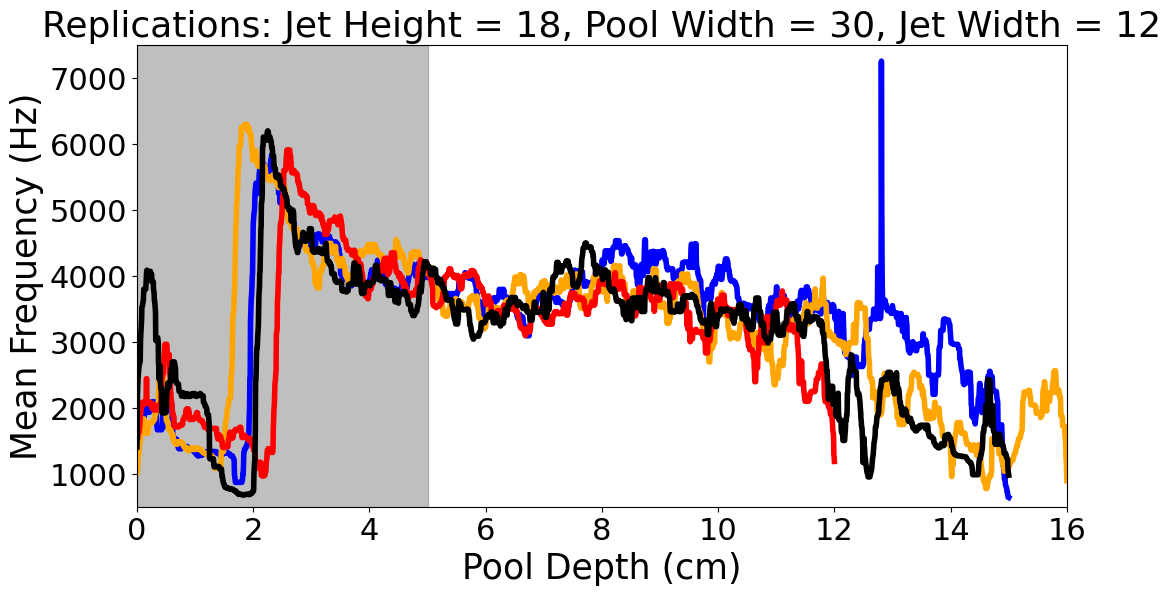

In [8]:
## THIS PLOTS A PARENT SPECTROGRAM, POWER + PARENT SPECTROGRAM, AND SUB SPECTRA BASED ON TIME WINDOWS
#meta_labels = ['Plunge Width = 33 cm', 'Plunge Width = 16.5 cm', '']
plot_labels = ['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10','R11','R12','R13','R14','R15','R16','R17','R18','R19','R20','R21','R22','R23','R24','R25','R26','R27','R28','R29','R30','R31','R32','R33','R34','R35']
plot_labels2 = ['A','B','C','D','E']

fig, ax = plt.subplots(1, 1,figsize = (12,6)) # Power plot
ax.set_xlabel('Pool Depth (cm)', fontsize = 25)
ax.set_ylabel('Power (Pa$^2$)', fontsize = 25)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

fig2, ax2 = plt.subplots(1, 1,figsize = (12,6)) # Freq plot
ax2.set_xlabel('Pool Depth (cm)', fontsize = 25)
ax2.set_ylabel('Mean Frequency (Hz)', fontsize = 25)
ax2.tick_params(axis='x', labelsize=22)
ax2.tick_params(axis='y', labelsize=22)

for i in [27,28,29,30]: # 4,5,7 compare pool widths, 0,1,34 for jet width, 2,3,4 for jet height, 8,9,10 for bed type, 27,28,29,30 for replication1, 23,24,25,26 for replications2
    photo_files  = sorted(glob.glob(path_photos + 'R' + str(i+1) + '/*.png'))
    # photo1 = Image.open(photo_files[0])
    # im1 = photo1.filter(ImageFilter.EDGE_ENHANCE)
    # photo2 = Image.open(photo_files[1])
    # im2 = photo2.filter(ImageFilter.EDGE_ENHANCE)
    # photo3 = Image.open(photo_files[2])
    # im3 = photo3.filter(ImageFilter.EDGE_ENHANCE)
    # photo4 = Image.open(photo_files[3])
    # im4 = photo4.filter(ImageFilter.EDGE_ENHANCE)
    # photo5 = Image.open(photo_files[4])
    # im5 = photo5.filter(ImageFilter.EDGE_ENHANCE)
    print(i)
    data = dataSet[i]
    
    start = data.sig_start[i]  
    end = data.sig_end[i]
    start_depth = data.d_initial[i]
    end_depth = data.d_final[i]
    times_audible = []
    meanspec_list_audible = []
    medspec_list_audible = []
    power_audible = []
    aud_freqs_low = [400]
    aud_freqs_high = [15000]
    #aud_power_band_limit = [[] for _ in range(len(aud_freqs_low))]

    spec_windows_low = [data.spec1start, data.spec2start, data.spec3start, data.spec4start, data.spec5start] # OPTIMAL PHASE & SPECTRA WINDOWS 
    spec_windows_high = [data.spec1end, data.spec2end, data.spec3end, data.spec4end, data.spec5end]
    # phase_windows_low = [data.phase1start, data.phase2start, data.phase3start, data.phase4start]
    # phase_windows_high = [data.phase1end, data.phase2end, data.phase3end, data.phase4end]

    file = aud_files[i]

    tr_audible = riversound.read_audiomoth(file, station = 'MicW_i437',remove_response = True) # read in and remove dc offset
    nfft_audible = next_power_2(0.1 / tr_audible.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz, finer freq resolution for coarser time resolution
    t1 = tr_audible.stats.starttime
    t2 = tr_audible.stats.endtime
    aud_spec_info = riversound.spectrum(tr_audible, nfft = nfft_audible, kurtosis_threshold = 200, overlap = 0.75) # 3/4 of each window overlap, causing double time resolution runmed_radius_t = 10, runmed_radius_f = 10
    freqs_audible_all = aud_spec_info['freqs']
    # TRIM FREQUENCIES AND TIMES
    ind =  (freqs_audible_all < aud_freqs_high[0]) & (freqs_audible_all > aud_freqs_low[0])
    freqs_audible_all = freqs_audible_all[ind]
    specgram_all = aud_spec_info['specgram'][ind]
    times_audible_all = aud_spec_info['times']
    meanspec_list_all = aud_spec_info['mean'][ind]
    #ind2 = (times_audible_all > start) & (times_audible_all < end)
    #times_audible_all = (times_audible_all > start) & (times_audible_all < end)
    power_audible_all = np.sum(specgram_all, axis = 0)  * np.diff(freqs_audible_all)[0]
    power_audible_all = obspy.signal.util.smooth(power_audible_all,16) # 16 smoothing parameters
    # for k in [0]: # audible
    #         indices = (freqs_audible_all > aud_freqs_low[k]) & (freqs_audible_all < aud_freqs_high[k])
    #         aud_power_band_limit[k].append(np.sum(specgram_all[indices,:], axis = 0) * np.diff(aud_spec_info['freqs'])[0]
    print(tr_audible)
    
    x = [data.d_t_initial[i], data.d_t_final[i]] # time = x axis
    y = [data.d_initial[i], data.d_final[i]] # depth = y axis 
    t_new = np.linspace(x[0],x[1],num = len(power_audible_all))
    y_interp = interp1d(x,y) # depth interpolation function
    depth = y_interp(t_new) # depth vec
    t_interp = interp1d(times_audible_all, power_audible_all) # setup interpolation between times_audible_all and power_audible_all using t_new as input to function
    power_new = t_interp(t_new)
    
    power_new = np.nan_to_num(power_new, nan = 0.000075) # replace nans 
    # scshot_times = (np.array([data.pic_a, data.pic_b, data.pic_c, data.pic_d, data.pic_e]))
    # scshot_depths = y_interp(scshot_times)
    # scshot_power = t_interp(scshot_times)
    #depth_times = depth(times_audible_all(data.pic_a), data.pic_b, data.pic_c, data.pic_d, data.pic_e)
    
    ax.plot(depth, power_new,'-', label = voi + '= ' + str(data[voi][i]) + ' cm', c = mcolors.hex2color(str(data.Color[i])), linewidth = 4)
    
    # plt.figure(10, figsize = (10,6)) # plot all images of pool as separate figures/images
    # img = PIL.Image.open(photo_files[0][:,:,1])
    # converter = ImageEnhance.Brightness(img)
    # img2 = converter.enhance(0.5)
    # plt.plot(img2)
    
    # plt.figure(20, figsize = (10,6))
    # img = PIL.Image.open('B78.png')
    # converter = ImageEnhance.Brightness(img)
    # img2 = converter.enhance(0.5)
    # plt.plot(img2)
    
    # plt.figure(30, figsize = (10,6))
    # img = PIL.Image.open('C94.png')
    # converter = ImageEnhance.Brightness(img)
    # img2 = converter.enhance(0.5)
    # plt.plot(img2)
    
    # plt.figure(40, figsize = (10,6))
    # img = PIL.Image.open('D107.png')
    # converter = ImageEnhance.Brightness(img)
    # img2 = converter.enhance(0.5)
    # plt.plot(img2)
    
    # plt.figure(50, figsize = (10,6))
    # img = PIL.Image.open('E147.png')
    # converter = ImageEnhance.Brightness(img)
    # img2 = converter.enhance(0.5)
    # plt.plot(img2)
    # scshot_power = np.array([np.max(power_new), np.max(power_new), np.max(power_new), np.max(power_new), np.max(power_new)])
    # scshot_freq = np.array([np.max(freqs_audible_all), np.max(freqs_audible_all), np.max(freqs_audible_all), np.max(freqs_audible_all), np.max(freqs_audible_all)])
    # ax.plot(scshot_depths[0], scshot_power[0], marker="$A$", markersize=10, color = 'black', markeredgecolor="black")
    # ax.plot(scshot_depths[1], scshot_power[0], marker="$B$", markersize=10, color = 'black', markeredgecolor="black")
    # ax.plot(scshot_depths[2], scshot_power[0], marker="$C$", markersize=10, color = 'black', markeredgecolor="black")
    # ax.plot(scshot_depths[3], scshot_power[0], marker="$D$", markersize=10, color = 'black', markeredgecolor="black")
    # ax.plot(scshot_depths[4], scshot_power[0], marker="$E$", markersize=10, color = 'black', markeredgecolor="black")
    pre_filt = riversound.find_mean_freq(specgram_all.T, freqs_audible_all, freqmin = aud_freqs_low, freqmax = aud_freqs_high)
    freq_filt = scipy.signal.medfilt(pre_filt, 43)
    ax2.plot(depth, freq_filt, '-', label = voi + '= ' + str(data[voi][i]) + ' cm', c = mcolors.hex2color(str(data.Color[i])), linewidth = 4)
    # ax2.plot(scshot_depths[0], scshot_freq[0], marker="$A$", markersize=10, color = 'black', markeredgecolor="black")
    # ax2.plot(scshot_depths[1], scshot_freq[0], marker="$B$", markersize=10, color = 'black', markeredgecolor="black")
    # ax2.plot(scshot_depths[2], scshot_freq[0], marker="$C$", markersize=10, color = 'black', markeredgecolor="black")
    # ax2.plot(scshot_depths[3], scshot_freq[0], marker="$D$", markersize=10, color = 'black', markeredgecolor="black")
    # ax2.plot(scshot_depths[4], scshot_freq[0], marker="$E$", markersize=10, color = 'black', markeredgecolor="black")
    
    depth_train = depth.reshape((-1,1))
    depth_test = depth.reshape((-1,1))
    # Split the targets into training/testing sets
    power_train = power_new.reshape((-1,1))
    power_test = power_new.reshape((-1,1))
    # regr = linear_model.LinearRegression()
    # regr.fit(depth_train, power_train)
    # power_pred = regr.predict(depth_test)
    # power_upperlim = power_test + mean_squared_error(power_test,power_pred)
    # power_lowerlim = power_test - mean_squared_error(power_test,power_pred)
    # ax.plot(depth_test,power_test, 'k--')
    # ax.plot(depth_test, power_upperlim, 'k--')
    # ax.plot(depth_test, power_lowerlim, 'k--')
    
    #ax.plot(depth_test,power_pred, 'k-')

    #depth_linreg = depth.reshape((-1,1))
    #model = LinearRegression().fit(depth_linreg, power_new)
    #ax.semilogy(depth, model,'.-', label = voi + '= ' + str(data[voi][i]) + '', c = mcolors.hex2color(str(data.Color[i])))
    # fig = plt.figure(constrained_layout = True)
    # fig.set_size_inches(6.5,9)
    # gs = gridspec.GridSpec(4,5, figure = fig)
    # sf1= plt.subplot(gs[0,:])
    # sf2 = plt.subplot(gs[1,:])
    # sf3 = plt.subplot(gs[2,0])
    # sf4 = plt.subplot(gs[2,1])
    # sf5 = plt.subplot(gs[2,2])
    # sf6 = plt.subplot(gs[2,3])
    # sf7 = plt.subplot(gs[2,4])
    # sf8 = plt.subplot(gs[3,:])
    # #plt.figure(figsize = (12,8))
    # #gs.suptitle('R'+ str(i+1))
    # #plt.subplot(2,1,1)
    # #plt.semilogy(y_new,power_audible_all)
    # sf1.semilogy(times_audible_all, power_audible_all)
    # sf1.set_title('R' + str(i+1) + ': | Drop Height=' + str(data.Drop_Height[i]) + ' | Pool Width=' + str(data.Pool_Width[i]) + ' | Plunge Width =' + str(data.Plunge_Width[i]) + ' | Bed =' + str(data.Bed[i]))
    # # sf1.ylabel('Power (Pa $^2$)', fontsize = 20)
    # xlim = [start,end] 
    # #ylim = [np.nanmin(specgram_all), np.nanmax(specgram_all)]
    # sf1.set_xlim(xlim[0], xlim[1])
    # #sf1.set_ylim(ylim[0],ylim[1])
    # sf1.tick_params(right = False, labelbottom = False, bottom = False)
    # sf1.set_ylabel('Power (Pa$^2$)', fontsize = 10)
    # #plt.gca()
    # # sf1.axvspan(int(spec_windows_low[0]), int(spec_windows_high[0]), color = 'red',alpha = 0.3) 
    # # sf1.axvspan(int(spec_windows_low[1]), int(spec_windows_high[1]), color = 'red',alpha = 0.3) 
    # # sf1.axvspan(int(spec_windows_low[2]), int(spec_windows_high[2]), color = 'red',alpha = 0.3) 
    # # sf1.axvspan(int(spec_windows_low[3]), int(spec_windows_high[3]), color = 'red',alpha = 0.3) 
    # # sf1.axvspan(int(spec_windows_low[4]), int(spec_windows_high[4]), color = 'red',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[0]), int(phase_windows_high[0]), color = 'none',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[1]), int(phase_windows_high[1]), color = 'none',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[2]), int(phase_windows_high[2]), color = 'none',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[3]), int(phase_windows_high[3]), color = 'none',alpha = 0.3) 
    # sf1.plot(data.pic_a, 0.9E-6, marker="$A$", markersize=10, color = 'black', markeredgecolor="black")
    # sf1.plot(data.pic_b, 0.9E-6, marker="$B$", markersize=10, color = 'black', markeredgecolor="black")
    # sf1.plot(data.pic_c, 0.9E-6, marker="$C$", markersize=10, color = 'black', markeredgecolor="black")
    # sf1.plot(data.pic_d, 0.9E-6, marker="$D$", markersize=10, color = 'black', markeredgecolor="black")
    # sf1.plot(data.pic_e, 0.9E-6, marker="$E$", markersize=10, color = 'black', markeredgecolor="black")
    
    # #plt.subplot(2,1,2)
    # #riversound.image(np.log10(specgram_all.T), times_audible_all, freqs_audible_all, crosshairs = False, log_y = False, qmax = 1)
    # xlim = [start,end] 
    # sf2.set_xlim(xlim[0], xlim[1])
    # #seconds = np.linspace(,220,num = 11)
    # #ax.set_xticks(seconds, fontsize = 20)
    # #ax.tick_params(axis='both', which='major', labelsize=18)
    # #sf2.set_yticks(fontsize = 16)
    # sf2.set_xlabel("Time (s)", fontsize = 10)
    # sf2.set_ylabel('Frequency (Hz)', fontsize = 10)
    # riversound.image(np.log10(specgram_all.T), times_audible_all, freqs_audible_all, crosshairs = False, log_y = True, qmax = 1, ax = sf2)

    # # ticks = 10**np.arange(5)
    # # ticks = ticks[3:]
    # # sf2.set_yticks(ticks, fontsize =10)
    # # sf2.set_yticklabels(ticks)
    # # sf2.set_yticks([350,1000,10000])
    # # sf2.axvspan(int(spec_windows_low[0]), int(spec_windows_high[0]), color = 'red',alpha = 0.3) # spec1
    # # sf2.axvspan(int(spec_windows_low[1]), int(spec_windows_high[1]), color = 'red',alpha = 0.3) 
    # # sf2.axvspan(int(spec_windows_low[2]), int(spec_windows_high[2]), color = 'red',alpha = 0.3) 
    # # sf2.axvspan(int(spec_windows_low[3]), int(spec_windows_high[3]), color = 'red',alpha = 0.3) 
    # # sf2.axvspan(int(spec_windows_low[4]), int(spec_windows_high[4]), color = 'red',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[0]), int(phase_windows_high[0]), color = 'none',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[1]), int(phase_windows_high[1]), color = 'none',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[2]), int(phase_windows_high[2]), color = 'none',alpha = 0.3) 
    # # plt.axvspan(int(phase_windows_low[3]), int(phase_windows_high[3]), color = 'none',alpha = 0.3) 
    # # sf2.plot(data.pic_a, np.log10(freqs_audible_all[-150]), marker="*", markersize=10, color = 'black', markeredgecolor="black")
    # # sf2.plot(data.pic_b, np.log10(freqs_audible_all[-150]), marker="*", markersize=10,color = 'black', markeredgecolor="black")
    # # sf2.plot(data.pic_c, np.log10(freqs_audible_all[-150]), marker="*", markersize=10, color = 'black', markeredgecolor="black")
    # # sf2.plot(data.pic_d, np.log10(freqs_audible_all[-150]), marker="*", markersize=10, color = 'black', markeredgecolor="black")
    # # sf2.plot(data.pic_e, np.log10(freqs_audible_all[-150]), marker="*", markersize=10, color = 'black', markeredgecolor="black")
    # ticks = np.arange(5)
    # ticks = ticks[3:]
    # sf2.set_yticks(ticks)
    # sf2.set_yticklabels(['10$^3$','10$^4$'])

    # plt.figure(10)
    # plt.imshow(mpimg.imread(photo_files[0]), aspect = data.aspect[i]) # options: aspect = 'auto', origin = 'lower', extent = (-1,0 ,-1,0)
    # plt.title('A')
    # plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    # plt.figure(15)
    # plt.imshow(mpimg.imread(photo_files[1]), aspect = data.aspect[i])
    # plt.title('B')
    # plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    # plt.figure(20)
    # plt.imshow(mpimg.imread(photo_files[2]), aspect = data.aspect[i])
    # plt.title('C')
    # plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    # plt.figure(30)
    # plt.imshow(mpimg.imread(photo_files[3]), aspect = data.aspect[i])
    # plt.title('D')
    # plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    # plt.figure(40)
    # plt.imshow(mpimg.imread(photo_files[4]), aspect = data.aspect[i])
    # plt.title('E')
    # plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    # ### TRIM DATA FOR SPECTRA CALC ###
    # meanspec_list_audible = [[] for i in range(len(spec_windows_low))]
    # times_audible = [[] for i in range(len(spec_windows_low))] 
    # trim1 = t1 + spec_windows_low[0]
    # trim2 = t1 + spec_windows_high[0]
    # window1 = tr_audible.slice(trim1,trim2)

    # trim11 = t1 + spec_windows_low[1]
    # trim22 = t1 + spec_windows_high[1]
    # window2 = tr_audible.slice(trim11,trim22)

    # trim111 = t1 + spec_windows_low[2]
    # trim222 = t1 + spec_windows_high[2]
    # window3 = tr_audible.slice(trim111,trim222)

    # trim1111 = t1 + spec_windows_low[3]
    # trim2222 = t1 + spec_windows_high[3]
    # window4 = tr_audible.slice(trim1111,trim2222)

    # trim11111 = t1 + spec_windows_low[4]
    # trim22222 = t1 + spec_windows_high[4]
    # window5 = tr_audible.slice(trim11111,trim22222)
    # window_full = [window1, window2, window3, window4, window5] # full time window

    # #fig1, ax1 = plt.subplots(1, 1,figsize = (12,8)) # PSD PLOT
    # #sf8.set_title('Power spectral density')
    # sf8.set_xlabel('Frequency (hz)')
    # sf8.set_ylabel('Power(Pa$^2$/hz)')
    # plot_labels2 = ['A','B','C','D','E']

    # # PLOT POWER SPECTRAL DENSITY FOR EACH WINDOW
    # for j, window in enumerate(window_full):
    #     t1 = window.stats.starttime
    #     t2 = window.stats.endtime
    #     nfft_audible = next_power_2(0.1 / window.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz, finer freq resolution for coarser time resolution
    #     aud_spec_info = riversound.spectrum(window, nfft = nfft_audible, kurtosis_threshold = 2000, overlap = 0.75) # 3/4 of each window overlap, causing double time resolution 
    #     freqs_audible = aud_spec_info['freqs']
    #     meanspec_list_audible = aud_spec_info['mean']
    #     specgram = aud_spec_info['specgram']
    #     times_audible = aud_spec_info['times']
    #     ind =  (freqs_audible < aud_freqs_high[0]) & (freqs_audible > aud_freqs_low[0])
    #     smoothed = obspy.signal.util.smooth(meanspec_list_audible[:],10)
    #     smoothed = smoothed[ind]
    #     power_audible = np.sum(specgram, axis = 0)  * np.diff(freqs_audible)[0]
    #     specgram = aud_spec_info['specgram'][ind]
    #     meanspec_list_audible = aud_spec_info['mean'][ind]
    #     freqs_audible = freqs_audible[ind]
    #     print(window)

    #     # buid sub-figure
    #     #plt.figure(figsize = (8,4))
    #     # plt.suptitle(plot_labels[i],fontsize = 20)
    #     # plt.subplot(2,1,1)
    #     # plt.semilogy(times_audible, power_audible, linewidth = 3, label = 'All Audible Frequencies')
    #     # plt.xticks([])
    #     # plt.ylabel('Power (Pa$^2$)', fontsize = 20)
    #     #for y in aud_power_band_limit:
    #         #plt.semilogy(times_audible, y, linewidth = 2, label = '50-500 Hz Band')
    #     #plt.legend()
    #     # plt.yticks(fontsize = 20)
    #     # plt.minorticks_off()
    #     # v = [np.min(times_audible),np.max(times_audible), np.min(power_audible), np.max(power_audible)]
    #     # plt.axis(v) 
    #     # plt.subplot(2,1,2)
    #     # riversound.image(np.log10(specgram.T), times_audible, freqs_audible, crosshairs = False, log_y = True, qmax = 1) # play with qmax to adjust spectrogram, default is .98
    #     # #plt.yticks(np.arange(5),10**np.arange(5), fontsize = 20)
    #     # plt.ylabel('Frequency (hz)')
    #     # xlim = [np.min(times_audible), np.max(times_audible)]
    #     # #ylim = [np.min(freqs_audible), np.max(freqs_audible)]
    #     # plt.xlim(xlim[0], xlim[1])
    #     # plt.xlabel("Time (s)", fontsize = 20)
    #     # plt.ylabel('Frequency (Hz)', fontsize = 20)
    #     # seconds = np.linspace(20,200,num = 10)
    #     # plt.tight_layout()
    #     #smoothed = obspy.signal.util.smooth(meanspec_list_audible[:],10)
    #     smoothed2 = obspy.signal.util.smooth(meanspec_list_audible[:],10)
    #     sf8.loglog(freqs_audible, smoothed, label = plot_labels2[j])
    #     sf8.axis('tight')
    #     #ax2.loglog(freqs_audible, smoothed2, label = plot_labels2[i])#  moving average filter the meanspec_list_audible variable 
    #     # 10 sample moving average in smoothing kernal, b =1, a = 0.1. smoothie = window size (10 samples or so)then, downsample 
    # sf8.legend()
    #fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
#ax.legend(loc= 'best', prop={'size': 20})
ax.set_ylim(0, 0.0011)
ax.set_xlim(0,16)
#ax.set_title(voi + ' Experiment Power', fontsize = 26)
ax.set_title('Replications: Jet Height = 18, Pool Width = 30, Jet Width = 12',fontsize = 26)
ax.axvspan(0,5, color = 'gray', alpha = 0.5)
#ax2.legend(loc= 'best', prop={'size': 20})
ticks = [1*10**3,2*10**3,3*10**3,4*10**3,5*10**3,6*10**3,7*10**3]
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks)
ax2.set_xlim(0,16)
ax2.axvspan(0,5, color = 'gray', alpha = 0.5)
ax2.set_ylim(500,7500)
#ax2.set_title(voi + ' Experiment Mean Frequency', fontsize = 26)
ax2.set_title('Replications: Jet Height = 18, Pool Width = 30, Jet Width = 12',fontsize = 26)

os.chdir('/home/scott/bender/gradschool/publication/new_figs/1-31-24_figs/')
#fig.savefig(fname = 'power_' + voi, format = 'jpg', bbox_inches = 'tight')
#fig2.savefig(fname = 'freq_' + voi, format = 'jpg', bbox_inches = 'tight')
fig.savefig(fname = 'power_reps', format = 'jpg', bbox_inches = 'tight')
fig2.savefig(fname = 'freq_reps', format = 'jpg', bbox_inches = 'tight')
#ax2.set_title(voi + ' Experiment Frequency', fontsize = 26)

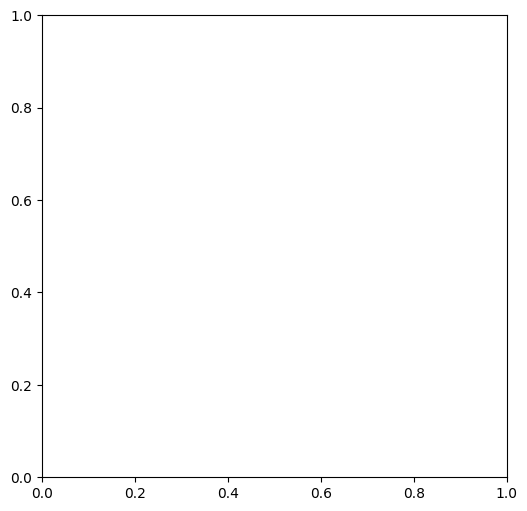

In [3]:
ax.get_ylim()
# ticks = ticks[3:]
### plot animation
dt = 0.01
tfinal = np.max(depth)
x0 = np.min(depth)

sqrtdt = np.sqrt(dt)
n = int(tfinal/dt)
xtraj = np.zeros(n+1, float)
trange = np.linspace(start=x0,stop=tfinal ,num=n+1)
xtraj[0] = x0

for i in range(n):
    xtraj[i+1] = xtraj[i] + np.random.normal()
x = trange
y = xtraj

# animation line plot example

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

def animate(i):
    ax.cla() # clear the previous image
    ax.plot(x[:i], y[:i]) # plot the line
    ax.set_xlim([x0, tfinal]) # fix the x axis
    ax.set_ylim([1.1*np.min(y), 1.1*np.max(y)]) # fix the y axis

anim = animation.FuncAnimation(fig, animate, frames = len(x) + 1, interval = 1, blit = False)
plt.show()

In [12]:
path1 = '/home/scott/bender/gradschool/data/2022_Pool/iMic/06-28_LG/from_kelvin/'
path2 = '/home/scott/bender/gradschool/data/2022_Pool/iMic/07-01_Div/'
path3 = '/home/scott/bender/gradschool/data/2022_Pool/iMic/10-06_Div/'
path4 = '/home/scott/bender/gradschool/data/2022_Pool/iMic/11-03_Div/'
path5 = '/home/scott/bender/gradschool/data/2022_Pool/iMic/11-11_LG/'
path6 = '/home/scott/bender/gradschool/data/2022_Pool/iMic/11-18_LG&Div/'
aud_files  = sorted(glob.glob(path2 + '*.wav'))
#path_photos = path + 'pool_screenshots/07-01/'
times_audible = []
meanspec_list_audible = []
medspec_list_audible = []
power_audible = []

.MicW_i437.. | 2022-07-01T15:39:22.000000Z - 2022-07-01T15:43:08.602646Z | 48000.0 Hz, 10876928 samples
.MicW_i437.. | 2022-07-01T16:06:41.000000Z - 2022-07-01T16:10:00.509312Z | 48000.0 Hz, 9576448 samples


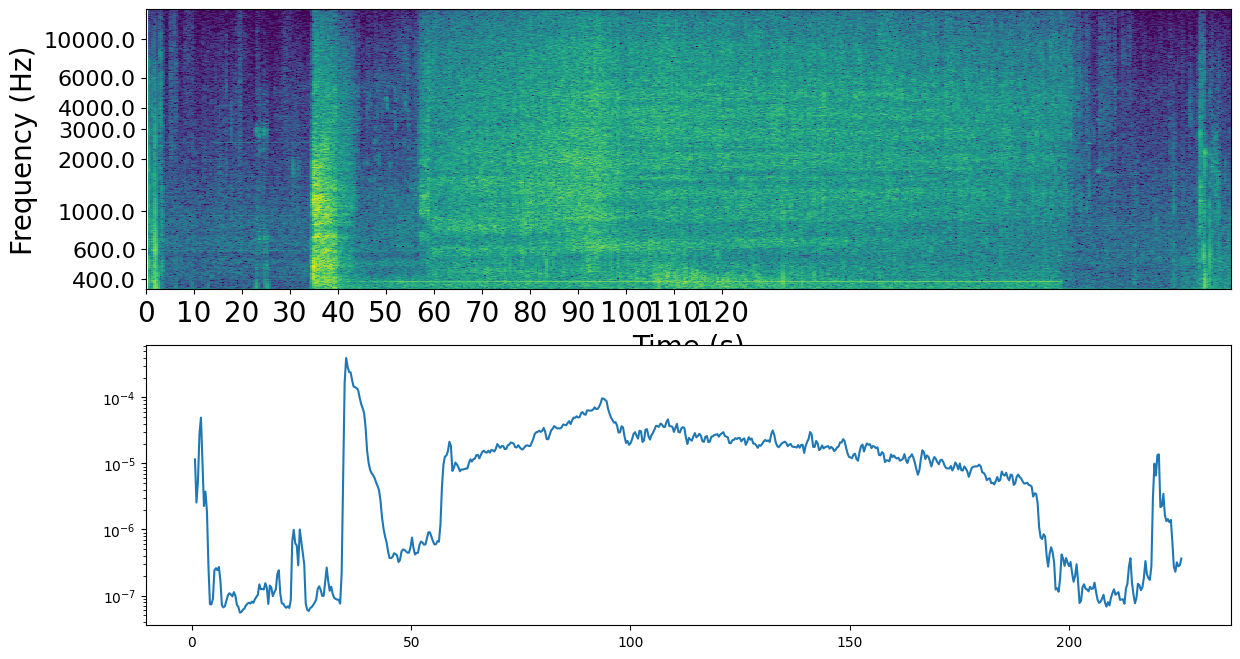

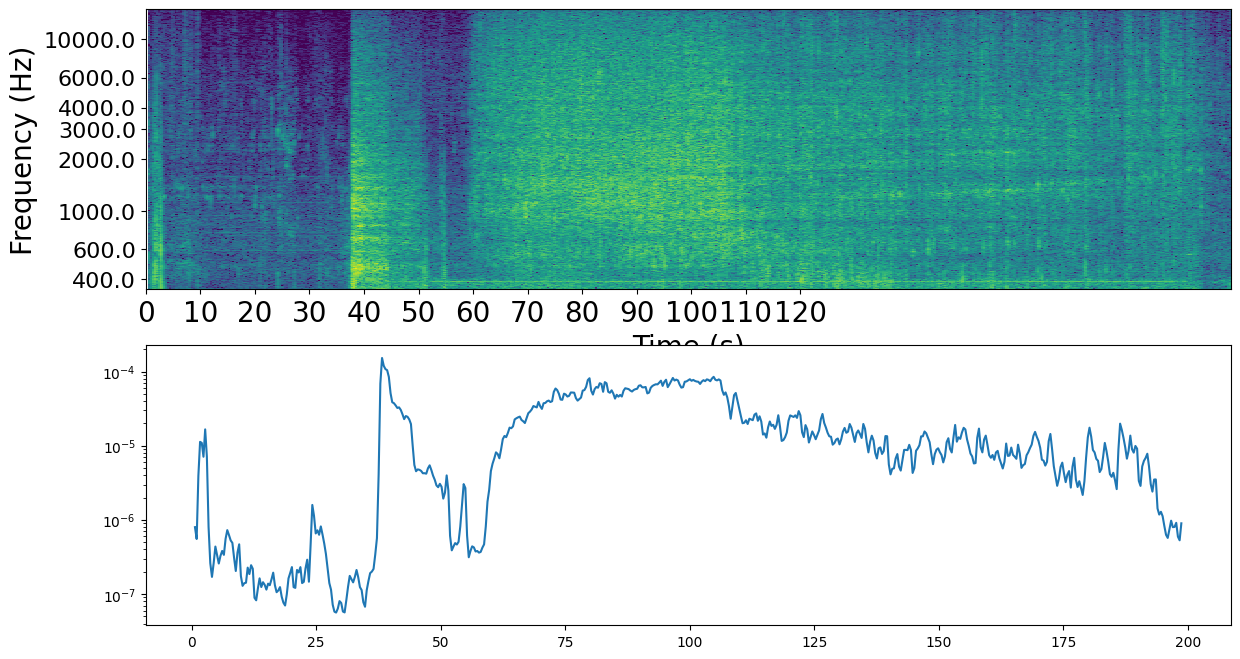

In [14]:
### VIEW DATA QUICKLY ###
aud_freqs_low = [350]
aud_freqs_high = [15000]
aud_files_index1 = [aud_files[i] for i in (0,1)] # R1,R2,R11,R12
for file in aud_files_index1: 
    tr_audible = riversound.read_audiomoth(file, station = 'MicW_i437',remove_response = True) # read in and remove dc offset
    nfft_audible = next_power_2(1 / tr_audible.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz, finer freq resolution for coarser time resolution
    t1 = tr_audible.stats.starttime
    t2 = tr_audible.stats.endtime
    aud_spec_info = riversound.spectrum(tr_audible, nfft = nfft_audible, kurtosis_threshold = 2000, overlap = 0.75) # 3/4 of each window overlap, causing double time resolution 
    freqs_audible_all = aud_spec_info['freqs']
    specgram_all = aud_spec_info['specgram']
    times_audible_all = aud_spec_info['times']
    # TRIM FREQUENCIES 
    ind =  (freqs_audible_all < aud_freqs_high[0]) & (freqs_audible_all > aud_freqs_low[0])
    freqs_audible_all = freqs_audible_all[ind]
    specgram_all = aud_spec_info['specgram'][ind]
    power_audible_all = np.sum(specgram_all, axis = 0)  * np.diff(aud_spec_info['freqs'])[0]
    diff_power = np.diff(power_audible_all)
    diff_power_all = np.append(diff_power, 0)
    #for k in [0]: # audible
    #        indices = (freqs_audible_all > aud_freqs_low[k]) & (freqs_audible_all < aud_freqs_high[k])
    #        aud_power_band_limit[k].append(np.sum(aud_spec_info['mean'][indices]) * np.diff(aud_spec_info['freqs'])[0])
    print(tr_audible)

    # #  PLOT PARENT SPECTROGRAM 

    plt.figure(figsize = (14,8))
    plt.subplot(2,1,1)
    plt.gca()
    #plt.title('R' + str(aud_files[i]+1))
    # ax = plt.axes()
    riversound.image(np.log10(specgram_all.T), times_audible_all, freqs_audible_all, crosshairs = False, log_y = True, qmax = 1) # play with qmax to adjust spectrogram, default is .98
    plt.yticks(fontsize = 16)
    seconds = np.linspace(0,120,num = 13)
    plt.xticks(seconds, fontsize = 20)
    plt.xlabel("Time (s)", fontsize = 20)
    plt.ylabel('Frequency (Hz)', fontsize = 20)
    #v = [np.min(times_audible_all),np.max(times_audible_all), np.min(power_audible_all), np.max(power_audible_all)]
    #plt.axis(v) # this aligns axes 
    plt.subplot(2,1,2)
    plt.semilogy(times_audible_all,power_audible_all)
    #v = [np.min(times_audible_all),np.max(times_audible_all)]
    #plt.axis(v) # this aligns axes 
    
    # # PLOT RECTANGLES FOR EACH TIME WINDOW
    # # specify the location of (left,bottom),    width,   height
    # # width = 20 # specify width if needed

    # rect1 = mpatches.Rectangle((40,np.min(specgram_all.T)),20,4, fill = False, color = "black", linewidth = 2)
    # plt.gca().add_patch(rect1)
    # plt.text(50, 4,'A',fontsize=28, color="red", weight="bold")

    # rect2 = mpatches.Rectangle((60,np.min(specgram_all.T)),20,4, fill = False, color = "black", linewidth = 2)
    # plt.gca().add_patch(rect2)
    # plt.text(70, 4,'B',fontsize=28, color="red", weight="bold")

    # rect3 = mpatches.Rectangle((80,np.min(specgram_all.T)),70,4, fill = False, color = "black", linewidth = 2)
    # plt.gca().add_patch(rect3)
    # plt.text(120, 4,'C',fontsize=28, color="red", weight="bold")

    # rect4 = mpatches.Rectangle((150,np.min(specgram_all.T)),40 ,4, fill = False, color = "black", linewidth = 2)
    # plt.gca().add_patch(rect4)
    # plt.text(170, 4,'D',fontsize=28, color="red", weight="bold")

    #for y in aud_power_band_limit:
    #    plt.semilogy(times_audible_all, y, linewidth = 2, label = '500-10000 Hz Band')
    # TRIM DATA FOR SPECTRA CALC

    # windows_low = [40,60,80,150] # adjust these depending on group
    # windows_high = [60,80,150,190]
    # meanspec_list_audible = [[] for i in range(len(windows_low))]
    # times_audible_all = [[] for i in range(len(windows_low))] 
    # #windows_range = windows_high-windows_low
    # #windows_loop = [[] for i in range(len(windows_low))]
    # trim1 = t1 + windows_low[0]
    # trim2 = t1 + windows_high[0]
    # window1 = tr_audible.slice(trim1,trim2)

    # trim11 = t1 + windows_low[1]
    # trim22 = t1 + windows_high[1]
    # window2 = tr_audible.slice(trim11,trim22)

    # trim111 = t1 + windows_low[2]
    # trim222 = t1 + windows_high[2]
    # window3 = tr_audible.slice(trim111,trim222)

    # trim1111 = t1 + windows_low[3]
    # trim2222 = t1 + windows_high[3]
    # window4 = tr_audible.slice(trim1111,trim2222)
    # window_full = [window1, window2, window3, window4] # full time window

    
    # fig, ax1 = plt.subplots(1, 1) # PSD PLOT
    # fig.suptitle('Power spectral density')
    # ax1.set_xlabel('Frequency (hz)')
    # ax1.set_ylabel('Power(Pa^2/hz)')
    # plot_labels = ['A','B','C','D']

    # PLOT POWER SPECTRAL DENSITY FOR EACH WINDOW
    # for i, window in enumerate(window_full):
    #     t1 = window.stats.starttime
    #     t2 = window.stats.endtime
    #     nfft_audible = next_power_2(1 / window.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz, finer freq resolution for coarser time resolution
    #     aud_spec_info = riversound.spectrum(window, nfft = nfft_audible, kurtosis_threshold = 20, overlap = 0.75) # 3/4 of each window overlap, causing double time resolution 
    #     freqs_audible = aud_spec_info['freqs']
        
    #     meanspec_list_audible = aud_spec_info['mean']
    #     specgram = aud_spec_info['specgram']
    #     times_audible = aud_spec_info['times']
    #     power_audible = np.sum(specgram, axis = 0)  * np.diff(aud_spec_info['freqs'])[0]
    #     print(window)

    #     buid sub-figure
    #     plt.figure(figsize = (8,4))
    #     plt.suptitle(plot_labels[i],fontsize = 20)
    #     plt.subplot(2,1,1)
    #     plt.semilogy(times_audible, power_audible, linewidth = 3, label = 'All Audible Frequencies')
    #     plt.xticks([])
    #     plt.xlabel('Time (s)', fontsize = 20)
    #     plt.ylabel('Power (Pa$^2$)', fontsize = 20)
    #     for y in aud_power_band_limit:
    #         plt.semilogy(times_audible, y, linewidth = 2, label = '50-500 Hz Band')
    #     plt.legend()
    #     plt.yticks(fontsize = 20)
    #     plt.minorticks_off()

    #     plt.subplot(3,1,2)
    #     plt.loglog(freqs_audible, meanspec_list_audible[:]) 

    #     plt.subplot(2,1,2)
    #     riversound.image(np.log10(specgram.T), times_audible, freqs_audible, crosshairs = False, log_y = True, qmax = 1) # play with qmax to adjust spectrogram, default is .98
    #     plt.yticks(np.arange(5),10**np.arange(5), fontsize = 20)
    #     plt.ylabel('Frequency (hz)')
    #     seconds = np.linspace(20,200,num = 10)

    #     ax1.loglog(freqs_audible, meanspec_list_audible[:], label = plot_labels[i])
    # ax1.legend()

In [ ]:
## THIS PLOTS A PARENT SPECTROGRAM, POWER + PARENT SPECTROGRAM, AND SUB SPECTRA BASED ON TIME WINDOWS
start = data.sig_start[0] # signal start
end = data.sig_end[0]
start_depth = data.d_initial[0]
end_depth = data.d_final[0]
times_audible = []
meanspec_list_audible = []
medspec_list_audible = []
power_audible = []
aud_freqs_low = [350]
aud_freqs_high = [10000]
aud_power_band_limit = [[] for i in range(len(aud_freqs_low))]

spec_windows_low = [data.spec1start, data.spec2start, data.spec3start, data.spec4start, data.spec5start] # OPTIMAL PHASE & SPECTRA WINDOWS 
spec_windows_high = [data.spec1end, data.spec2end, data.spec3end, data.spec4end, data.spec5end]
phase_windows_low = [data.phase1start, data.phase2start, data.phase3start, data.phase4start]
phase_windows_high = [data.phase1end, data.phase2end, data.phase3end, data.phase4end]

#######################
aud_files_index1 = [aud_files[i] for i in [0]] # R1 = 0
for j,file in enumerate(aud_files_index1):
    tr_audible = riversound.read_audiomoth(file, station = 'MicW_i437',remove_response = True) # read in and remove dc offset
    nfft_audible = next_power_2(1 / tr_audible.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz, finer freq resolution for coarser time resolution
    t1 = tr_audible.stats.starttime
    t2 = tr_audible.stats.endtime
    aud_spec_info = riversound.spectrum(tr_audible, nfft = nfft_audible, kurtosis_threshold = 200, overlap = 0.75) # 3/4 of each window overlap, causing double time resolution 
    freqs_audible_all = aud_spec_info['freqs']
    # TRIM FREQUENCIES AND TIMES
    ind =  (freqs_audible_all < aud_freqs_high[0]) & (freqs_audible_all > aud_freqs_low[0])
    freqs_audible_all = freqs_audible_all[ind]
    specgram_all = aud_spec_info['specgram'][ind]
    times_audible_all = aud_spec_info['times']
    #ind2 = (times_audible_all > start) & (times_audible_all < end)
    #times_audible_all = (times_audible_all > start) & (times_audible_all < end)
    power_audible_all = np.sum(specgram_all, axis = 0)  * np.diff(freqs_audible_all)[0]
    for k in [0]: # audible
            indices = (freqs_audible_all > aud_freqs_low[k]) & (freqs_audible_all < aud_freqs_high[k])
            aud_power_band_limit[k].append(np.sum(specgram_all[indices,:], axis = 0) * np.diff(aud_spec_info['freqs'])[0])
    print(tr_audible)
    x = [data.d_t_initial[0], data.d_t_final[0]] # time = x axis
    y = [data.d_initial[0], data.d_final[0]] # depth = y axis 
    x_new = np.linspace(x[0],x[1],num = len(power_audible_all))
    y_interp = interp1d(x,y)
    y_new = y_interp(x_new) # depth vec
    plt.figure()
    plt.plot(x,y,'o',x_new,y_new,'-')
    plt.xlabel('Time (s)')
    plt.ylabel('Pool Depth (cm)')
    #  PLOT PARENT SPECTROGRAM 
    # plt.figure(figsize = (12,6))
    # ax = plt.axes()
    # riversound.image(np.log10(specgram_all.T), times_audible_all, freqs_audible_all, crosshairs = False, log_y = True, qmax = 1) # play with qmax to adjust spectrogram, default is .98
    # plt.yticks(np.arange(5),10**np.arange(5), fontsize = 20)
    # seconds = np.linspace(20,220,num = 11)
    # ax.set_xticks(seconds, fontsize = 20)
    # xlim = [np.min(times_audible_all), np.max(times_audible_all)]
    # plt.xlim(xlim[0], xlim[1])
    # ax.set_ylim(np.min(specgram_all), np.max(specgram_all))
    # ax.tick_params(axis='both', which='major', labelsize=18)
    # plt.yticks(fontsize = 16)
    # plt.xlabel("Time (s)", fontsize = 20)
    # plt.ylabel('Frequency (Hz)', fontsize = 20)
    #### PLOT 2 PANEL FIGURE ####
    #def roundup(x):
     #   return int(math.ceil(x))
    #round_end = roundup(np.max(times_audible_all))
    #num = int(round_end/10)
    #ticks = np.linspace(0,round_end,num = num)
    #labels = np.arange(ticks)
    plt.figure(figsize = (12,8))
    #ax = plt.axes()
    plt.subplot(2,1,1)
    #plt.semilogy(y_new,power_audible_all)
    plt.semilogy(times_audible_all, power_audible_all)
    plt.ylabel('Power (Pa $^2$)', fontsize = 20)
    #v = [np.min(times_audible_all),np.max(times_audible_all), np.min(power_audible_all), np.max(power_audible_all)]
    #plt.axis(v) # this aligns axes 
    #xlim = [start_depth, end_depth]
    xlim = [start,end] 
    plt.xlim(xlim[0], xlim[1])
    plt.yticks(fontsize = 16)
    plt.gca()

    ## FIX INDICES HERE
    #rect1 = mpatches.Rectangle((phase_windows_low[0],np.min(specgram_all.T)+1),phase_windows_high[0]-phase_windows_low[0],500, fill = False, color = "black", linewidth = 2) # phase windows
    #circ1 = mpatches.Circle((spec_windows_low[0],np.max(specgram_all.T)),radius =(spec_windows_high[0]-spec_windows_low[0])/2, color = "red") # spectra windows 
    #plt.gca().add_patch(rect1)
    #plt.gca().add_patch(circ1)
    #plt.text((windows_high[0]+windows_low[0])/2, 5000,'A',fontsize=28, color="red", weight="bold")

    # rect2 = mpatches.Rectangle((phase_windows_low[1],np.min(specgram_all.T)+1),phase_windows_high[1]-phase_windows_low[1],5000, fill = False, color = "black", linewidth = 2) #
    # circ2 = mpatches.Circle((spec_windows_low[1],np.max(specgram_all.T)),radius =(spec_windows_high[1]-spec_windows_low[1])/2, color = "red")
    # #plt.gca().add_patch(rect2)
    # plt.gca().add_patch(circ2)
    # #plt.text((windows_high[1]+windows_low[1])/2, 5000,'B',fontsize=28, color="red", weight="bold")

    # rect3 = mpatches.Rectangle((phase_windows_low[2],np.min(specgram_all.T)+1),phase_windows_high[2]-phase_windows_low[2],5000, fill = False, color = "black", linewidth = 2)#
    # circ3 = mpatches.Circle((spec_windows_low[2],np.max(specgram_all.T)),radius =(spec_windows_high[2]-spec_windows_low[2])/2, color = "red")
    # #plt.gca().add_patch(rect3)
    # plt.gca().add_patch(circ3)
    # #plt.text((windows_high[2]+windows_low[2])/2, 5000,'C',fontsize=28, color="red", weight="bold")

    # rect4 = mpatches.Rectangle((phase_windows_low[3],np.min(specgram_all.T+1)), phase_windows_high[3]-phase_windows_low[3],5000, fill = False, color = "black", linewidth = 2)
    # circ4 = mpatches.Circle((spec_windows_low[3],np.max(specgram_all.T)),radius =(spec_windows_high[3]-spec_windows_low[3])/2, color = "red")
    # #plt.gca().add_patch(rect4)
    # plt.gca().add_patch(circ4)
    # #plt.text((windows_high[3]+windows_low[3])/2, 5000,'D',fontsize=28, color="red", weight="bold")

    # circ5 = mpatches.Circle((spec_windows_low[4],np.max(specgram_all.T+1)),radius =(spec_windows_high[4]-spec_windows_low[4])/2, color = "red")
    # plt.gca().add_patch(circ5)
    
    plt.subplot(2,1,2)
    riversound.image(np.log10(specgram_all.T), times_audible_all, freqs_audible_all, crosshairs = False, log_y = True, qmax = 1) # play with qmax to adjust spectrogram, default is .98
    #riversound.image(np.log10(specgram_all.T), y_new, freqs_audible_all, crosshairs = False, log_y = True, qmax = 1)
    #v = [np.min(times_audible_all),np.max(times_audible_all), np.min(power_audible_all), np.max(power_audible_all)]
    #plt.axis(v) # this aligns axes 
    xlim = [start,end] 
    #xlim = [start_depth, end_depth]
    plt.xlim(xlim[0], xlim[1])
    #plt.yticks(np.arange(5),10**np.arange(5), fontsize =9)
    #ylim = [np.min(freqs_audible_all), np.max(freqs_audible_all)]
    #plt.xlim(xlim[0], xlim[1])
    #plt.ylim(ylim[0], ylim[1])
    #seconds = np.linspace(20,220,num = 11)
    #ax.set_xticks(seconds, fontsize = 20)
    #ax.tick_params(axis='both', which='major', labelsize=18)
    plt.yticks(fontsize = 16)
    plt.xlabel("Time (s)", fontsize = 20)
    plt.ylabel('Frequency (Hz)', fontsize = 20)
    plt.tight_layout()
    # circ1 = mpatches.Circle((spec_windows_low[0],np.max(specgram_all.T+1)),radius =(spec_windows_high[0]-spec_windows_low[0])/2, color = "red")
    # circ2 = mpatches.Circle((spec_windows_low[1],np.max(specgram_all.T+1)),radius =(spec_windows_high[1]-spec_windows_low[1])/2, color = "red")
    # circ3 = mpatches.Circle((spec_windows_low[2],np.max(specgram_all.T+1)),radius =(spec_windows_high[2]-spec_windows_low[2])/2, color = "red")
    # circ4 = mpatches.Circle((spec_windows_low[3],np.max(specgram_all.T+1)),radius =(spec_windows_high[3]-spec_windows_low[3])/2, color = "red")
    # circ5 = mpatches.Circle((spec_windows_low[4],np.max(specgram_all.T+1)),radius =(spec_windows_high[4]-spec_windows_low[4])/2, color = "red")
    # plt.gca()
    # plt.gca().add_patch(circ1)
    # plt.gca().add_patch(circ2)
    # plt.gca().add_patch(circ3)
    # plt.gca().add_patch(circ4)
    # plt.gca().add_patch(circ5)
    #v = [np.min(times_audible_all),np.max(times_audible_all), np.min(power_audible_all), np.max(power_audible_all)]
    #plt.axis(v) # this aligns axes 
    #xlim = [start,end]
    #plt.xlim(xlim[0], xlim[1])
    # specify the location of (left,bottom), width, height

    #rect1 = mpatches.Rectangle((phase_windows_low[0],np.min(specgram_all.T+1)),phase_windows_high[0]-phase_windows_low[0],5000, fill = True, color = "black", linewidth = 2,)
    #plt.gca().add_patch(rect1)
    #plt.text((windows_high[0]+windows_low[0])/2, 50,'A',fontsize=28, color="red", weight="bold")

    # rect2 = mpatches.Rectangle((phase_windows_low[1],np.min(specgram_all.T+1)),phase_windows_high[1]-phase_windows_low[1],5000, fill = False, color = "black", linewidth = 2)
    # #plt.gca().add_patch(rect2)
    # #plt.text((windows_high[1]+windows_low[1])/2, 5000,'B',fontsize=28, color="red", weight="bold")

    # rect3 = mpatches.Rectangle((phase_windows_low[2],np.min(specgram_all.T+1)),phase_windows_high[2]-phase_windows_low[2],5000, fill = False, color = "black", linewidth = 2)
    # #plt.gca().add_patch(rect3)
    # #plt.text((windows_high[2]+windows_low[2])/2, 5000,'C',fontsize=28, color="red", weight="bold")

    # rect4 = mpatches.Rectangle((phase_windows_low[3],np.min(specgram_all.T+1)), phase_windows_high[3]-phase_windows_low[3],5000, fill = False, color = "black", linewidth = 2)
    # #plt.gca().add_patch(rect4)
    # #plt.text((windows_high[3]+windows_low[3])/2, 5000,'D',fontsize=28, color="red", weight="bold")
    
    ### TRIM DATA FOR SPECTRA CALC ###
    meanspec_list_audible = [[] for i in range(len(spec_windows_low))]
    times_audible = [[] for i in range(len(spec_windows_low))] 
    trim1 = t1 + spec_windows_low[0]
    trim2 = t1 + spec_windows_high[0]
    window1 = tr_audible.slice(trim1,trim2)

    trim11 = t1 + spec_windows_low[1]
    trim22 = t1 + spec_windows_high[1]
    window2 = tr_audible.slice(trim11,trim22)

    trim111 = t1 + spec_windows_low[2]
    trim222 = t1 + spec_windows_high[2]
    window3 = tr_audible.slice(trim111,trim222)

    trim1111 = t1 + spec_windows_low[3]
    trim2222 = t1 + spec_windows_high[3]
    window4 = tr_audible.slice(trim1111,trim2222)

    trim11111 = t1 + spec_windows_low[4]
    trim22222 = t1 + spec_windows_high[4]
    window5 = tr_audible.slice(trim11111,trim22222)
    window_full = [window1, window2, window3, window4, window5] # full time window

    fig, ax1 = plt.subplots(1, 1) # PSD PLOT
    fig.suptitle('Power spectral density')
    ax1.set_xlabel('Frequency (hz)')
    ax1.set_ylabel('Power(Pa^2/hz)')
    plot_labels = ['A','B','C','D','E']

    # fig, ax2 = plt.subplots(1, 1) # PSD SMOOTHED PLOT
    # fig.suptitle('Power spectral density')
    # ax2.set_xlabel('Frequency (hz)')
    # ax2.set_ylabel('Power(Pa$^2$/hz)')
    # plot_labels2 = ['A','B','C','D','E']

    # PLOT POWER SPECTRAL DENSITY FOR EACH WINDOW
    for i, window in enumerate(window_full):
        t1 = window.stats.starttime
        t2 = window.stats.endtime
        nfft_audible = next_power_2(1 / window.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz, finer freq resolution for coarser time resolution
        aud_spec_info = riversound.spectrum(window, nfft = nfft_audible, kurtosis_threshold = 2000, overlap = 0.75) # 3/4 of each window overlap, causing double time resolution 
        freqs_audible = aud_spec_info['freqs']
        meanspec_list_audible = aud_spec_info['mean']
        specgram = aud_spec_info['specgram']
        times_audible = aud_spec_info['times']
        ind =  (freqs_audible < aud_freqs_high[0]) & (freqs_audible > aud_freqs_low[0])
        freqs_audible = freqs_audible[ind]
        power_audible = np.sum(specgram, axis = 0)  * np.diff(freqs_audible)[0]
        specgram = aud_spec_info['specgram'][ind]
        meanspec_list_audible = aud_spec_info['mean'][ind]
        print(window)

        # buid sub-figure
        #plt.figure(figsize = (8,4))
        # plt.suptitle(plot_labels[i],fontsize = 20)
        # plt.subplot(2,1,1)
        # plt.semilogy(times_audible, power_audible, linewidth = 3, label = 'All Audible Frequencies')
        # plt.xticks([])
        # plt.ylabel('Power (Pa$^2$)', fontsize = 20)
        #for y in aud_power_band_limit:
            #plt.semilogy(times_audible, y, linewidth = 2, label = '50-500 Hz Band')
        #plt.legend()
        # plt.yticks(fontsize = 20)
        # plt.minorticks_off()
        # v = [np.min(times_audible),np.max(times_audible), np.min(power_audible), np.max(power_audible)]
        # plt.axis(v) 

        # plt.subplot(2,1,2)
        # riversound.image(np.log10(specgram.T), times_audible, freqs_audible, crosshairs = False, log_y = True, qmax = 1) # play with qmax to adjust spectrogram, default is .98
        # #plt.yticks(np.arange(5),10**np.arange(5), fontsize = 20)
        # plt.ylabel('Frequency (hz)')
        # xlim = [np.min(times_audible), np.max(times_audible)]
        # #ylim = [np.min(freqs_audible), np.max(freqs_audible)]
        # plt.xlim(xlim[0], xlim[1])
        # plt.xlabel("Time (s)", fontsize = 20)
        # plt.ylabel('Frequency (Hz)', fontsize = 20)
        # seconds = np.linspace(20,200,num = 10)
        # plt.tight_layout()
        smoothed = obspy.signal.util.smooth(meanspec_list_audible[:],20)
        smoothed2 = obspy.signal.util.smooth(meanspec_list_audible[:],10)
        ax1.loglog(freqs_audible, smoothed, label = plot_labels[i])
        #ax2.loglog(freqs_audible, smoothed2, label = plot_labels2[i])#  moving average filter the meanspec_list_audible variable 
        # 10 sample moving average in smoothing kernal, b =1, a = 0.1
        # smoothie = window size (10 samples or so)
        # then, downsample 
    ax1.legend()


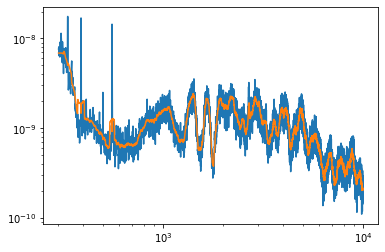

In [24]:
## play with smoothing filter 

import obspy.signal 
plt.figure()

plt.loglog(freqs_audible, meanspec_list_audible[:])

smoothed = obspy.signal.util.smooth(meanspec_list_audible[:],20)

plt.loglog(freqs_audible,smoothed)
# explore median filters

In [ ]:
# plot all data in folder quickly
## NOTE: CLEAR ALL VARIABLES BEFORE RUNNING
for file in aud_files:
    tr_audible = riversound.read_audiomoth(file, station = 'MicW_i437',remove_response = True) # read in and remove dc offset
    # trim data for individual files
    t1 = tr_audible.stats.starttime
    t2 = tr_audible.stats.endtime
    nfft_audible = next_power_2(1 / tr_audible.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz, finer freq resolution for coarser time resolution
    aud_spec_info = riversound.spectrum(tr_audible, nfft = nfft_audible, kurtosis_threshold = 20, overlap = 0.75) # 3/4 of each window overlap, causing double time resolution 
    freqs_audible_all = aud_spec_info['freqs']
    specgram = aud_spec_info['specgram']
    times_audible = aud_spec_info['times']
    power_audible = np.sum(specgram, axis = 0)  * np.diff(aud_spec_info['freqs'])[0]
    print(tr_audible)

    # buid figure
    plt.figure(figsize = (16,8))
    plt.subplot(2,1,1)
    plt.semilogy(times_audible, power_audible, linewidth = 3, label = 'All Audible Frequencies')
    plt.xticks([])
    plt.xlabel('Time (s)', fontsize = 20)
    plt.ylabel('Power (Pa$^2$)', fontsize = 20)
    #for y in aud_power_band_limit:
        #plt.semilogy(times_audible, y, linewidth = 2, label = '50-500 Hz Band')
    plt.legend()
    plt.yticks(fontsize = 20)
    plt.minorticks_off()
    plt.title(str(t1), fontsize = 20)
    
    plt.subplot(2,1,2)
    riversound.image(np.log10(specgram.T), times_audible, freqs_audible_all, crosshairs = False, log_y = True, qmax = 1) # play with qmax to adjust spectrogram, default is .98
    plt.yticks(np.arange(5),10**np.arange(5), fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 16)
    plt.xlabel(f"Time (s) after {str(t1)}", fontsize = 20)
    plt.ylabel('Frequency (Hz)', fontsize = 20)
    
for k in [0]: # audible
        indices = (freqs_audible_all > aud_freqs_low[k]) & (freqs_audible_all < aud_freqs_high[k])
        aud_power_band_limit[k].append(np.sum(aud_spec_info['mean'][indices]) * np.diff(aud_spec_info['freqs'])[0])

In [ ]:
# video analysis in cv2 
import cv2 as cv
vid_file = '/data/jakeanderson/2022/Pool/video/07-01/DSC_5477.MOV'
video = cv.VideoCapture(vid_file)

ret,img = video.read()
if ret:
    imgin = img[:,:,(2,1,0)]
cv.imshow('img', img)


In [ ]:

def get_frames(filename): # read in video file, returns true if frame is read correctly
    video=cv.VideoCapture(filename)
    while video.isOpened():
        rete,frame=video.read()
        if rete:
            yield frame
        else:
            break
        video.release()
        yield None

for f in get_frames(vid_file): # display frames of the video
    if f is None:
        break
    cv.imshow('frame',f)
    if cv.waitKey(10) == 40:
        break
cv.destroyAllWindows()

def get_frame(filename,index): # grabs a single frame
    counter=0
    video=cv.VideoCapture(filename)
    while video.isOpened():
        rete,frame=video.read()
        if rete:
            if counter==index:
                return frame
            counter +=1
        else:
            break
    video.release()
    return None

frame = get_frame(vid_file,45) # index position 45
print('shape is', frame.shape)
print('pixel at (60,21)',frame[60,21,:]) # I think this displays rgb vector at position 60,21
print('pixel at (120,10)',frame[120,10,:])
plt.imshow(frame) # show the frame


# region of interest tracking code:

ret,frame = video.read()
# setup initial location of window
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
while(1):
    ret, frame = video.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply camshift to get the new location
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        # Draw it on image
        pts = cv.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, 255,2)
        cv.imshow('img2',img2)
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break









# check and plot data
ind =  (freqs_audible_all < 20000) & (freqs_audible_all > 40)
freqs_audible = freqs_audible_all[ind]    
meanspec_audible = reformat(meanspec_list_audible)[:,ind]    
medspec_audible = reformat(medspec_list_audible)[:,ind]
#power_audible = reformat(power_audible)

# check data, plot
plt.figure(1)
plt.loglog(freqs_audible_all,meanspec_list_audible[0]) 
# correct beginning time axis
pdtimes_audible =  pd.to_datetime(times_audible)
t = np.array(times_audible)
indices1 = ([0,1,2,3,4,5])
g = pdtimes_audible.strftime('%R')
g = [g[inds] for inds in indices1]
